In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'MFC Variation 6 LSTM Time Series'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Manulife Financial Corporation Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.09375,6.133837,-56.250000,1982400.0,2.0
2000-01-24,6.06250,6.122862,-60.000000,1705200.0,2.0
2000-01-25,5.96875,6.099153,-80.000000,909600.0,2.0
2000-01-26,6.00000,6.083898,-73.333333,1179600.0,2.0
2000-01-27,5.96875,6.066183,-80.000000,783000.0,2.0


In [6]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [7]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [8]:
y = labels
y = np.array(y)
y.shape

(4745,)

In [9]:
from collections import Counter

Counter(y)

Counter({2.0: 4303, 1.0: 214, 0.0: 228})

In [10]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [11]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [12]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 40ms/step - loss: 0.2930 - accuracy: 0.4768 - mse: 0.4614 - weighted_accuracy: 0.3134 - weighted_mse: 0.5236 - val_loss: 0.2998 - val_accuracy: 0.0453 - val_mse: 0.3548 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3548
Epoch 2/200
30/30 [==============================] - 0s 13ms/step - loss: 0.2076 - accuracy: 0.3061 - mse: 0.8109 - weighted_accuracy: 0.4409 - weighted_mse: 0.7769 - val_loss: 0.2904 - val_accuracy: 0.0453 - val_mse: 0.3840 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3840
Epoch 3/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1859 - accuracy: 0.2684 - mse: 1.0647 - weighted_accuracy: 0.5179 - weighted_mse: 1.0230 - val_loss: 0.2787 - val_accuracy: 0.0453 - val_mse: 0.4197 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4197
Epoch 4/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1790 - accuracy: 0.2637 - mse: 1.1958 - weighted_accuracy: 0.5291 - weig

Epoch 30/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1387 - accuracy: 0.3804 - mse: 1.6918 - weighted_accuracy: 0.6871 - weighted_mse: 1.5832 - val_loss: 0.1984 - val_accuracy: 0.3267 - val_mse: 1.6855 - val_weighted_accuracy: 0.3267 - val_weighted_mse: 1.6855
Epoch 31/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1380 - accuracy: 0.4052 - mse: 1.7027 - weighted_accuracy: 0.7018 - weighted_mse: 1.5923 - val_loss: 0.1949 - val_accuracy: 0.3635 - val_mse: 1.6746 - val_weighted_accuracy: 0.3635 - val_weighted_mse: 1.6746
Epoch 32/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1367 - accuracy: 0.3970 - mse: 1.7101 - weighted_accuracy: 0.6916 - weighted_mse: 1.5929 - val_loss: 0.1901 - val_accuracy: 0.3699 - val_mse: 1.6920 - val_weighted_accuracy: 0.3699 - val_weighted_mse: 1.6920
Epoch 33/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1370 - accuracy: 0.4025 - mse: 1.7343 - weighted_accuracy: 0.7043 - 

Epoch 59/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1138 - accuracy: 0.5817 - mse: 2.2283 - weighted_accuracy: 0.8004 - weighted_mse: 2.1076 - val_loss: 0.1933 - val_accuracy: 0.4310 - val_mse: 2.2932 - val_weighted_accuracy: 0.4310 - val_weighted_mse: 2.2932
Epoch 60/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1129 - accuracy: 0.5685 - mse: 2.2387 - weighted_accuracy: 0.7923 - weighted_mse: 2.1348 - val_loss: 0.1804 - val_accuracy: 0.4942 - val_mse: 2.4331 - val_weighted_accuracy: 0.4942 - val_weighted_mse: 2.4331
Epoch 61/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1135 - accuracy: 0.5635 - mse: 2.2869 - weighted_accuracy: 0.7918 - weighted_mse: 2.1729 - val_loss: 0.1784 - val_accuracy: 0.5005 - val_mse: 2.3587 - val_weighted_accuracy: 0.5005 - val_weighted_mse: 2.3587
Epoch 62/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1112 - accuracy: 0.5893 - mse: 2.2516 - weighted_accuracy: 0.8137 - 

30/30 [==============================] - 0s 16ms/step - loss: 0.0908 - accuracy: 0.6981 - mse: 2.9409 - weighted_accuracy: 0.8608 - weighted_mse: 2.8126 - val_loss: 0.1847 - val_accuracy: 0.5311 - val_mse: 3.1198 - val_weighted_accuracy: 0.5311 - val_weighted_mse: 3.1198
Epoch 88/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0900 - accuracy: 0.6826 - mse: 2.9838 - weighted_accuracy: 0.8571 - weighted_mse: 2.8549 - val_loss: 0.1563 - val_accuracy: 0.6344 - val_mse: 3.2768 - val_weighted_accuracy: 0.6344 - val_weighted_mse: 3.2768
Epoch 89/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0880 - accuracy: 0.7023 - mse: 2.9648 - weighted_accuracy: 0.8748 - weighted_mse: 2.8266 - val_loss: 0.1758 - val_accuracy: 0.5648 - val_mse: 3.1768 - val_weighted_accuracy: 0.5648 - val_weighted_mse: 3.1768
Epoch 90/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0871 - accuracy: 0.7042 - mse: 3.0272 - weighted_accuracy: 0.8738 - weighted_mse:

Epoch 116/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0703 - accuracy: 0.7832 - mse: 4.1374 - weighted_accuracy: 0.8994 - weighted_mse: 3.9182 - val_loss: 0.2404 - val_accuracy: 0.5427 - val_mse: 4.3161 - val_weighted_accuracy: 0.5427 - val_weighted_mse: 4.3161
Epoch 117/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0714 - accuracy: 0.7835 - mse: 4.1977 - weighted_accuracy: 0.9047 - weighted_mse: 3.9437 - val_loss: 0.2120 - val_accuracy: 0.5342 - val_mse: 4.4309 - val_weighted_accuracy: 0.5342 - val_weighted_mse: 4.4309
Epoch 118/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0662 - accuracy: 0.7806 - mse: 4.0837 - weighted_accuracy: 0.9124 - weighted_mse: 3.7985 - val_loss: 0.1648 - val_accuracy: 0.6754 - val_mse: 4.4002 - val_weighted_accuracy: 0.6754 - val_weighted_mse: 4.4002
Epoch 119/200
30/30 [==============================] - 1s 21ms/step - loss: 0.0650 - accuracy: 0.8048 - mse: 4.1926 - weighted_accuracy: 0.919

Epoch 145/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0513 - accuracy: 0.8477 - mse: 5.6515 - weighted_accuracy: 0.9352 - weighted_mse: 5.1082 - val_loss: 0.2011 - val_accuracy: 0.6628 - val_mse: 5.8871 - val_weighted_accuracy: 0.6628 - val_weighted_mse: 5.8871
Epoch 146/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0543 - accuracy: 0.8335 - mse: 5.6718 - weighted_accuracy: 0.9335 - weighted_mse: 5.1852 - val_loss: 0.1992 - val_accuracy: 0.6681 - val_mse: 5.8122 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 5.8122
Epoch 147/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0512 - accuracy: 0.8614 - mse: 5.7606 - weighted_accuracy: 0.9402 - weighted_mse: 5.2075 - val_loss: 0.1844 - val_accuracy: 0.7218 - val_mse: 6.6020 - val_weighted_accuracy: 0.7218 - val_weighted_mse: 6.6020
Epoch 148/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0497 - accuracy: 0.8646 - mse: 5.7461 - weighted_accuracy: 0.946

Epoch 174/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0377 - accuracy: 0.9062 - mse: 7.4925 - weighted_accuracy: 0.9619 - weighted_mse: 6.5274 - val_loss: 0.2061 - val_accuracy: 0.7313 - val_mse: 7.6366 - val_weighted_accuracy: 0.7313 - val_weighted_mse: 7.6366
Epoch 175/200
30/30 [==============================] - 1s 18ms/step - loss: 0.0354 - accuracy: 0.9125 - mse: 7.6374 - weighted_accuracy: 0.9660 - weighted_mse: 6.6096 - val_loss: 0.2129 - val_accuracy: 0.7155 - val_mse: 7.5074 - val_weighted_accuracy: 0.7155 - val_weighted_mse: 7.5074
Epoch 176/200
30/30 [==============================] - 1s 18ms/step - loss: 0.0380 - accuracy: 0.9052 - mse: 7.6559 - weighted_accuracy: 0.9598 - weighted_mse: 6.6757 - val_loss: 0.2071 - val_accuracy: 0.7408 - val_mse: 8.2080 - val_weighted_accuracy: 0.7408 - val_weighted_mse: 8.2080
Epoch 177/200
30/30 [==============================] - 1s 18ms/step - loss: 0.0364 - accuracy: 0.9062 - mse: 7.6906 - weighted_accuracy: 0.963

In [16]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22907036542892456
Test accuracy: 0.7449947595596313


In [17]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.44095472 -5.386717   -0.8839904 ]
 [-3.917535   -3.8619606   3.0589838 ]
 [-2.5642245  -2.9373207   1.7756354 ]
 ...
 [-2.34978    -1.257281   -0.2566157 ]
 [-1.1192158  -6.6338205   0.79252946]
 [-3.8042002  -8.8312645   3.2987652 ]]


Counter({0: 95, 2: 786, 1: 68})

In [18]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 46, 1: 43})

In [19]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 40
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 43
actual holds but predicted buy: 65
actual holds but predicted sell: 92
actual predicted holds: 703
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 81.74418604651163%
actual buys: 43
actual sells: 46
actual holds: 860


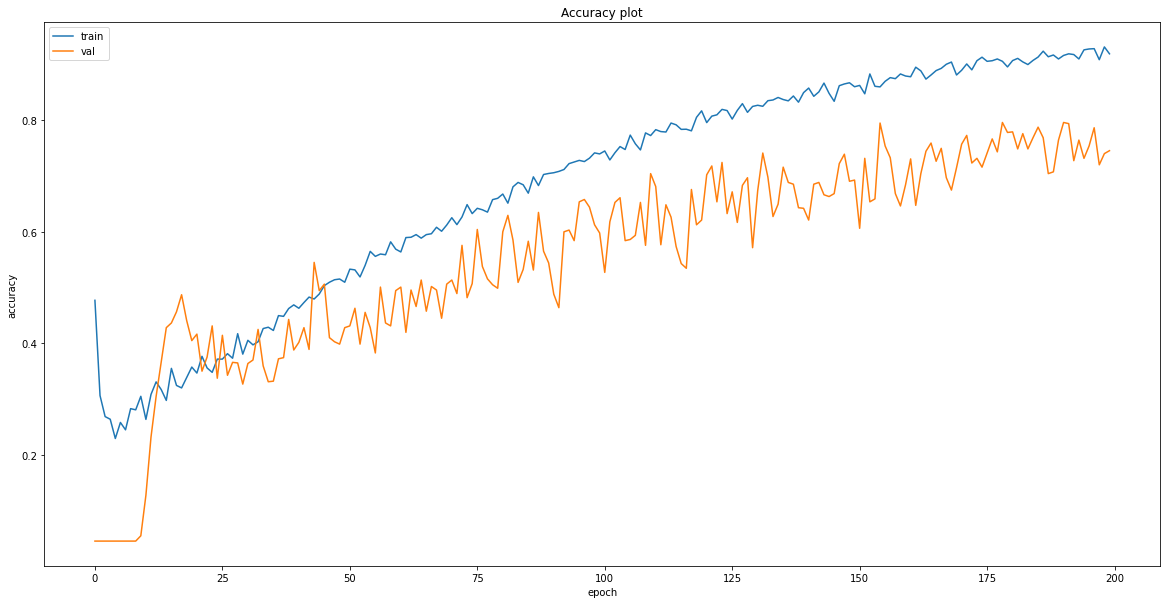

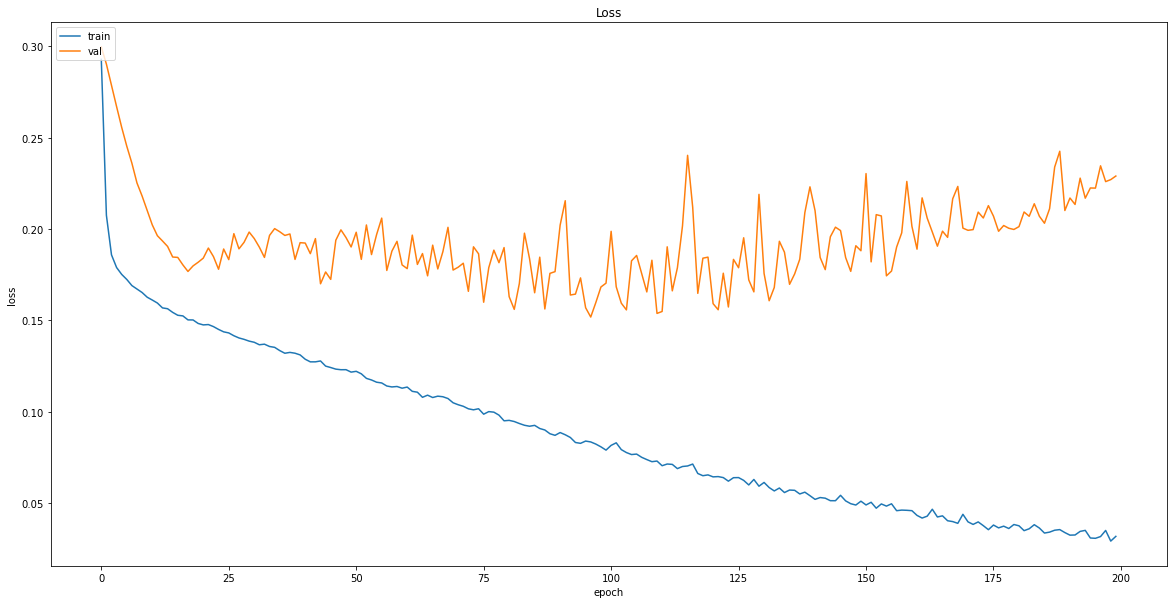

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
# Save model
model.save("models/{}".format('MFC_no_support_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/MFC_no_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [22]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [23]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,16.10,15.369379,-4.347841,12991200.0,2.0
2019-01-23,15.75,15.427936,-19.565241,11195700.0,2.0
2019-01-24,15.79,15.483638,-19.902947,12310800.0,2.0
2019-01-25,15.63,15.506155,-34.131754,10454700.0,2.0
2019-01-28,15.75,15.543670,-30.405447,11863600.0,2.0


In [24]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [25]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [26]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [27]:
model = tf.keras.models.load_model("models/MFC_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1700 - accuracy: 0.8119 - mean_squared_error: 10.3996 - weighted_accuracy: 0.8119 - weighted_mean_squared_error: 10.3996
Test loss: 0.1700063794851303
Test accuracy: 0.8119266033172607


In [28]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 191, 0: 17, 1: 10})

In [29]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 10, 2: 198, 0: 10})

In [30]:
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test.csv")
df.set_index('Date', inplace=True)

In [31]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,15.680000,15.815776,-56.451598,16809700.0,2.0,2,1
2019-02-11,15.630000,15.794888,-75.000000,15118200.0,1.0,2,2
2019-02-12,15.960000,15.769520,-80.303008,13534100.0,2.0,2,2
2019-02-13,15.800000,15.798825,-30.303008,15499400.0,2.0,2,2
2019-02-14,16.040001,15.799006,-54.545415,12941900.0,2.0,2,2


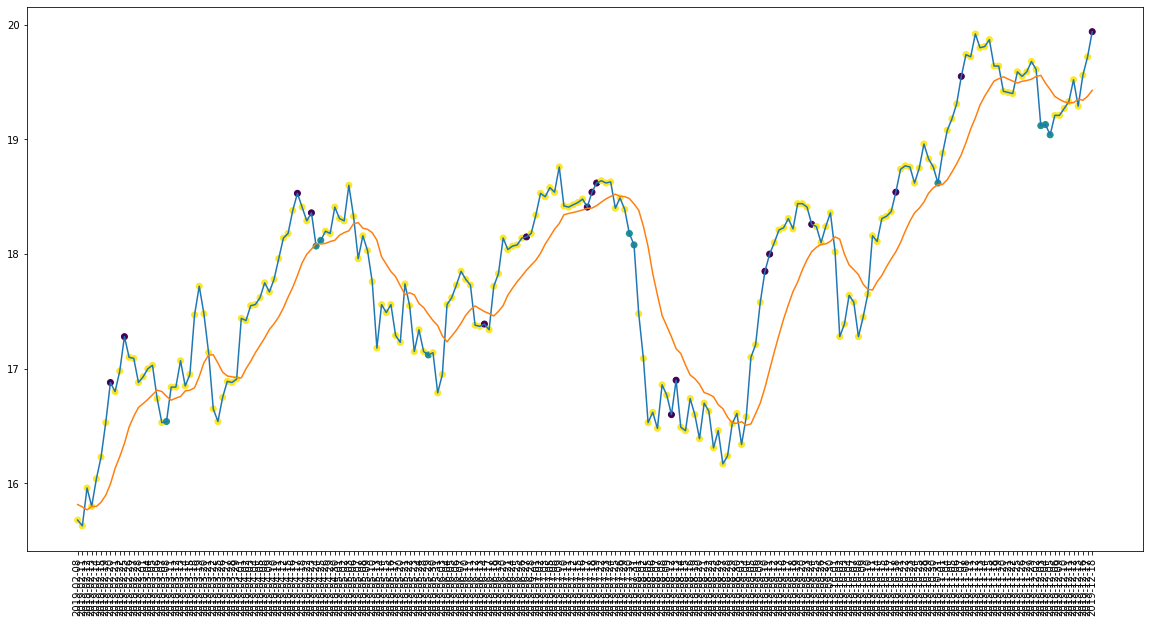

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 9
actual holds but predicted sell: 14
actual predicted holds: 175
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 88.38383838383838%
actual buys: 10
actual sells: 10
actual holds: 198


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[15.630000114440918, 15.68000030517578, 15.800000190734865, 15.960000038146973, 16.040000915527347, 16.229999542236328, 16.530000686645508, 16.799999237060547, 16.879999160766598]
[16.530000686645508, 16.799999237060547, 16.879999160766598, 16.879999160766598, 16.930000305175778, 16.979999542236328, 17.09000015258789, 17.100000381469727, 17.280000686645508]
Percentage buys correct: 80.0%
Percentage sells correct: 41.1764705882353%
Percentage holds correct: 86.38743455497382%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $16.540000915527347
Shares owned at the moment: 602
Cash capital at the moment: $15.537477336882148


Price increase from previously bought: 11.72419534892748%
Share price: $18.530000686645508
Shares owned at the moment: 0
Cash capital at the moment: $11139.921474560735


Share price: $18.06999969482422
Shares owned at the moment: 614
Cash capital at the moment: $14.430467453954407


Stop Loss Activated!

Share price: $17.180000305175778
Shares owned at the moment: 0
Cash capital at the moment: $10533.942224316592


Share price: $17.120000839233402
Shares owned at the moment: 613
Cash capital at the moment: $10.521668451778169


Price increase from previously bought: 5.725602308637634%
Share price: $18.149999618530273
Shares owned at the moment: 0
Cash capital at the moment: $11105.875072753897


Share price: $18.18000030517578
Shares owned at the moment: 609
Cash capital at the moment: $3.807931390752856


Stop Loss Activated!

Share price: $17.479999542236328
Shares owne

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12647.060764101027
profit gained: 26.470607641010265%


In [37]:
logger

[0.8119266033172607,
 '10.0%',
 '10.0%',
 '88.38383838383838%',
 '80.0%',
 '41.1764705882353%',
 '86.38743455497382%',
 '13.093821278943887%',
 '26.470607641010265%']

In [38]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.811927,10.0%,10.0%,88.38383838383838%,80.0%,41.1764705882353%,86.38743455497382%,13.093821278943887%,26.470607641010265%


### Recession Test Data

In [39]:
logger = []

In [40]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    20.620001  20.787224 -56.481365  5587900.0     2.0
2020-01-23    20.760000  20.783036 -48.453572  7034300.0     2.0
2020-01-24    20.799999  20.785645 -44.329960  8383300.0     2.0
2020-01-27    20.650000  20.764777 -59.793849  5159000.0     2.0
2020-01-28    20.030001  20.651734 -87.591226  2998800.0     2.0


In [41]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [42]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [43]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [44]:
model = tf.keras.models.load_model("models/MFC_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1374 - accuracy: 0.8265 - mean_squared_error: 10.2247 - weighted_accuracy: 0.8265 - weighted_mean_squared_error: 10.2247
Test loss: 0.1374119371175766
Test accuracy: 0.8264840245246887


In [45]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 0: 22, 1: 7})

In [46]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [47]:
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test2.csv")
df.set_index('Date', inplace=True)

In [48]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-10,19.910000,20.059596,-67.567554,-202200.0,2.0,2,0
2020-02-11,20.209999,20.036581,-63.157941,-1529300.0,0.0,2,2
2020-02-12,20.110001,20.063261,-43.421155,-126100.0,2.0,2,2
2020-02-13,19.719999,20.070452,-50.000000,-2453200.0,2.0,2,2
2020-02-14,19.709999,20.016536,-62.626362,-4848700.0,2.0,2,2


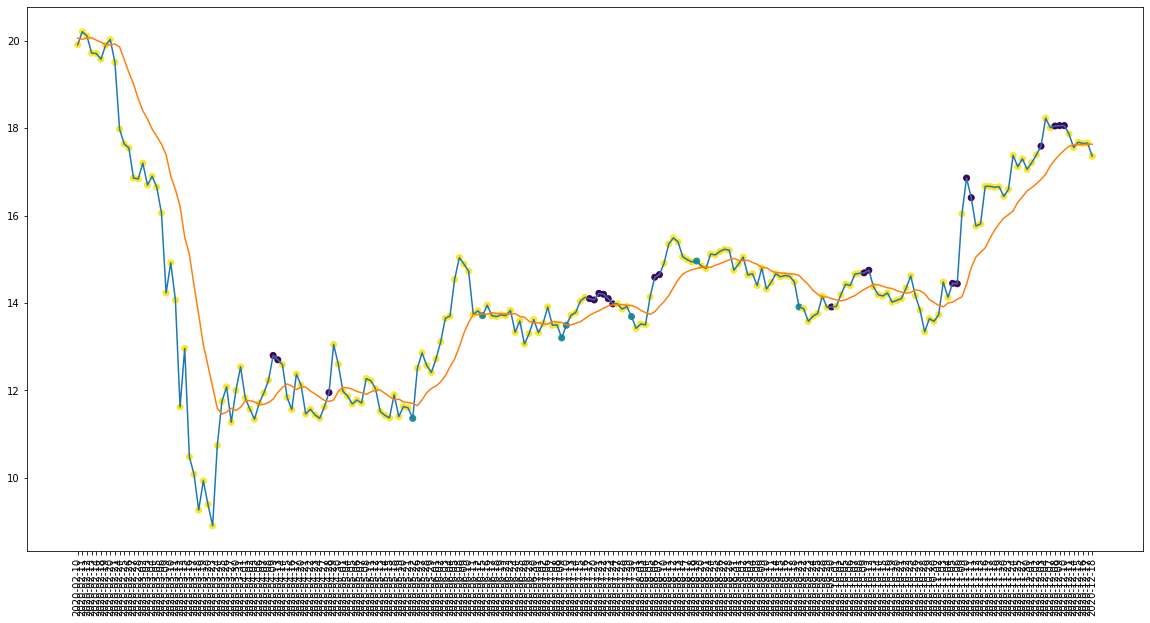

In [49]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [50]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))
logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 6
actual holds but predicted sell: 18
actual predicted holds: 176
Percentage buys correct: 12.5%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 88.0%
actual buys: 8
actual sells: 11
actual holds: 200


In [51]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[19.51000022888184, 19.57999992370605, 19.709999084472656, 19.71999931335449, 19.899999618530273, 19.90999984741211, 20.030000686645508, 20.11000061035156, 20.209999084472656]
[16.84000015258789, 16.860000610351562, 17.200000762939453, 17.549999237060547, 17.639999389648438, 17.979999542236328, 19.51000022888184, 19.899999618530273, 20.030000686645508]
Percentage buys correct: 85.71428571428571%
Percentage sells correct: 63.63636363636363%
Percentage holds correct: 84.73684210526316%


In [52]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.359999656677244
Shares owned at the moment: 877
Cash capital at the moment: $9.882821922064977


Price increase from previously bought: 23.77933225532065%
Share price: $14.100000381469727
Shares owned at the moment: 0
Cash capital at the moment: $12341.577480551005


Share price: $13.6899995803833
Shares owned at the moment: 899
Cash capital at the moment: $0.42275632381461037


Price increase from previously bought: 6.2818709454100174%
Share price: $14.59000015258789
Shares owned at the moment: 0
Cash capital at the moment: $13080.762765623092


Share price: $14.960000038146973
Shares owned at the moment: 871
Cash capital at the moment: $14.769792305707597


Stop Loss Activated!

Share price: $14.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $12522.677860959291


Share price: $13.90999984741211
Shares owned at the moment: 897
Cash capital at the moment: $11.095505707024131


Price increase from previously bought: 5.317850687944725%
Share pr

In [53]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8673.754130840302
profit gained: -13.262458691596985%


In [54]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.811927,10.0%,10.0%,88.38383838383838%,80.0%,41.1764705882353%,86.38743455497382%,13.093821278943887%,26.470607641010265%
1,0.826484,12.5%,36.36363636363637%,88.0%,85.71428571428571%,63.63636363636363%,84.73684210526316%,31.517885728459333%,-13.262458691596985%


### with JPM stock price

In [55]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.09375,6.133837,-56.250000,1982400.0,2.0
2000-01-24,6.06250,6.122862,-60.000000,1705200.0,2.0
2000-01-25,5.96875,6.099153,-80.000000,909600.0,2.0
2000-01-26,6.00000,6.083898,-73.333333,1179600.0,2.0
2000-01-27,5.96875,6.066183,-80.000000,783000.0,2.0


In [56]:
df2 = pd.read_csv("data/variation 6/initial_indicators/JPM_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [57]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2000-01-21,6.09375,6.133837,-56.250000,1982400.0,49.375000,2.0
2000-01-24,6.06250,6.122862,-60.000000,1705200.0,48.625000,2.0
2000-01-25,5.96875,6.099153,-80.000000,909600.0,48.666668,2.0
2000-01-26,6.00000,6.083898,-73.333333,1179600.0,49.750000,2.0
2000-01-27,5.96875,6.066183,-80.000000,783000.0,52.291668,2.0


In [58]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [59]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(4745, 15, 5)

In [60]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [61]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [62]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [64]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 2s 54ms/step - loss: 0.2979 - accuracy: 0.5340 - mse: 0.4398 - weighted_accuracy: 0.3253 - weighted_mse: 0.5214 - val_loss: 0.3009 - val_accuracy: 0.0421 - val_mse: 0.3536 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.3536
Epoch 2/200
30/30 [==============================] - 0s 16ms/step - loss: 0.2125 - accuracy: 0.3583 - mse: 0.7681 - weighted_accuracy: 0.4176 - weighted_mse: 0.7508 - val_loss: 0.2919 - val_accuracy: 0.0453 - val_mse: 0.3817 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3817
Epoch 3/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1895 - accuracy: 0.2937 - mse: 1.0117 - weighted_accuracy: 0.4695 - weighted_mse: 0.9794 - val_loss: 0.2799 - val_accuracy: 0.0453 - val_mse: 0.4150 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4150
Epoch 4/200
30/30 [==============================] - 1s 17ms/step - loss: 0.1810 - accuracy: 0.3024 - mse: 1.1534 - weighted_accuracy: 0.5108 - weig

Epoch 30/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1319 - accuracy: 0.4386 - mse: 1.6758 - weighted_accuracy: 0.7442 - weighted_mse: 1.5866 - val_loss: 0.1830 - val_accuracy: 0.4341 - val_mse: 1.6446 - val_weighted_accuracy: 0.4341 - val_weighted_mse: 1.6446
Epoch 31/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1306 - accuracy: 0.4652 - mse: 1.6815 - weighted_accuracy: 0.7468 - weighted_mse: 1.5952 - val_loss: 0.1813 - val_accuracy: 0.4552 - val_mse: 1.6036 - val_weighted_accuracy: 0.4552 - val_weighted_mse: 1.6036
Epoch 32/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1284 - accuracy: 0.4602 - mse: 1.6906 - weighted_accuracy: 0.7574 - weighted_mse: 1.5976 - val_loss: 0.1797 - val_accuracy: 0.4679 - val_mse: 1.7073 - val_weighted_accuracy: 0.4679 - val_weighted_mse: 1.7073
Epoch 33/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1290 - accuracy: 0.4700 - mse: 1.7117 - weighted_accuracy: 0.7538 - w

Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1004 - accuracy: 0.6805 - mse: 2.2698 - weighted_accuracy: 0.8557 - weighted_mse: 2.2200 - val_loss: 0.1980 - val_accuracy: 0.4953 - val_mse: 2.3246 - val_weighted_accuracy: 0.4953 - val_weighted_mse: 2.3246
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0984 - accuracy: 0.6473 - mse: 2.2932 - weighted_accuracy: 0.8510 - weighted_mse: 2.2485 - val_loss: 0.1847 - val_accuracy: 0.5100 - val_mse: 2.3278 - val_weighted_accuracy: 0.5100 - val_weighted_mse: 2.3278
Epoch 61/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0988 - accuracy: 0.6683 - mse: 2.3404 - weighted_accuracy: 0.8532 - weighted_mse: 2.2929 - val_loss: 0.1670 - val_accuracy: 0.5722 - val_mse: 2.3814 - val_weighted_accuracy: 0.5722 - val_weighted_mse: 2.3814
Epoch 62/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0966 - accuracy: 0.6839 - mse: 2.3262 - weighted_accuracy: 0.8644 - we

Epoch 88/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0687 - accuracy: 0.7911 - mse: 3.3087 - weighted_accuracy: 0.9196 - weighted_mse: 3.2360 - val_loss: 0.1496 - val_accuracy: 0.7028 - val_mse: 3.5941 - val_weighted_accuracy: 0.7028 - val_weighted_mse: 3.5941
Epoch 89/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0667 - accuracy: 0.8061 - mse: 3.3421 - weighted_accuracy: 0.9270 - weighted_mse: 3.2549 - val_loss: 0.1766 - val_accuracy: 0.6365 - val_mse: 3.4260 - val_weighted_accuracy: 0.6365 - val_weighted_mse: 3.4260
Epoch 90/200
30/30 [==============================] - 0s 17ms/step - loss: 0.0665 - accuracy: 0.8111 - mse: 3.3998 - weighted_accuracy: 0.9269 - weighted_mse: 3.3021 - val_loss: 0.1769 - val_accuracy: 0.6301 - val_mse: 3.5303 - val_weighted_accuracy: 0.6301 - val_weighted_mse: 3.5303
Epoch 91/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0669 - accuracy: 0.8027 - mse: 3.5076 - weighted_accuracy: 0.9203 - 

Epoch 117/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0489 - accuracy: 0.8659 - mse: 5.0105 - weighted_accuracy: 0.9453 - weighted_mse: 4.7432 - val_loss: 0.2304 - val_accuracy: 0.5985 - val_mse: 5.0631 - val_weighted_accuracy: 0.5985 - val_weighted_mse: 5.0631
Epoch 118/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0487 - accuracy: 0.8546 - mse: 5.1110 - weighted_accuracy: 0.9466 - weighted_mse: 4.8624 - val_loss: 0.1711 - val_accuracy: 0.7450 - val_mse: 5.4690 - val_weighted_accuracy: 0.7450 - val_weighted_mse: 5.4690
Epoch 119/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0455 - accuracy: 0.8786 - mse: 5.1994 - weighted_accuracy: 0.9535 - weighted_mse: 4.9646 - val_loss: 0.1750 - val_accuracy: 0.7260 - val_mse: 5.3952 - val_weighted_accuracy: 0.7260 - val_weighted_mse: 5.3952
Epoch 120/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0443 - accuracy: 0.8838 - mse: 5.2090 - weighted_accuracy: 0.957

Epoch 146/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0316 - accuracy: 0.9170 - mse: 7.2782 - weighted_accuracy: 0.9678 - weighted_mse: 6.5942 - val_loss: 0.2057 - val_accuracy: 0.7840 - val_mse: 7.8048 - val_weighted_accuracy: 0.7840 - val_weighted_mse: 7.8048
Epoch 147/200
30/30 [==============================] - 0s 15ms/step - loss: 0.0331 - accuracy: 0.9102 - mse: 7.3415 - weighted_accuracy: 0.9670 - weighted_mse: 6.6332 - val_loss: 0.2091 - val_accuracy: 0.7597 - val_mse: 7.9071 - val_weighted_accuracy: 0.7597 - val_weighted_mse: 7.9071
Epoch 148/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0314 - accuracy: 0.9160 - mse: 7.4654 - weighted_accuracy: 0.9674 - weighted_mse: 6.8031 - val_loss: 0.2083 - val_accuracy: 0.7766 - val_mse: 7.6541 - val_weighted_accuracy: 0.7766 - val_weighted_mse: 7.6541
Epoch 149/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0304 - accuracy: 0.9239 - mse: 7.6260 - weighted_accuracy: 0.972

Epoch 175/200
30/30 [==============================] - 0s 17ms/step - loss: 0.0214 - accuracy: 0.9513 - mse: 9.9474 - weighted_accuracy: 0.9821 - weighted_mse: 8.6809 - val_loss: 0.2443 - val_accuracy: 0.7756 - val_mse: 10.2358 - val_weighted_accuracy: 0.7756 - val_weighted_mse: 10.2358
Epoch 176/200
30/30 [==============================] - 1s 18ms/step - loss: 0.0243 - accuracy: 0.9415 - mse: 9.7523 - weighted_accuracy: 0.9785 - weighted_mse: 8.6035 - val_loss: 0.2542 - val_accuracy: 0.7734 - val_mse: 10.6292 - val_weighted_accuracy: 0.7734 - val_weighted_mse: 10.6292
Epoch 177/200
30/30 [==============================] - 0s 17ms/step - loss: 0.0234 - accuracy: 0.9455 - mse: 9.9153 - weighted_accuracy: 0.9800 - weighted_mse: 8.6588 - val_loss: 0.2365 - val_accuracy: 0.8030 - val_mse: 10.7595 - val_weighted_accuracy: 0.8030 - val_weighted_mse: 10.7595
Epoch 178/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0217 - accuracy: 0.9481 - mse: 10.1530 - weighted_accuracy

In [65]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.295114666223526
Test accuracy: 0.8008430004119873


In [66]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.27834406 -3.4525917  -0.45269957]
 [-3.4989     -1.5975069   0.96336406]
 [-4.387867   -3.2836678   2.23567   ]
 ...
 [-4.374145   -2.5655496   2.1444042 ]
 [-2.3837392  -5.126434    1.4380332 ]
 [-2.5859299  -4.960079    2.368595  ]]


Counter({0: 60, 2: 838, 1: 51})

In [67]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 46, 1: 43})

In [68]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 39
actual sells but predicted buy: 2
actual predicted sells: 1
actual sells but predicted hold: 43
actual holds but predicted buy: 46
actual holds but predicted sell: 58
actual predicted holds: 756
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 2.1739130434782608%
Percentage holds correct: 87.90697674418605%
actual buys: 43
actual sells: 46
actual holds: 860


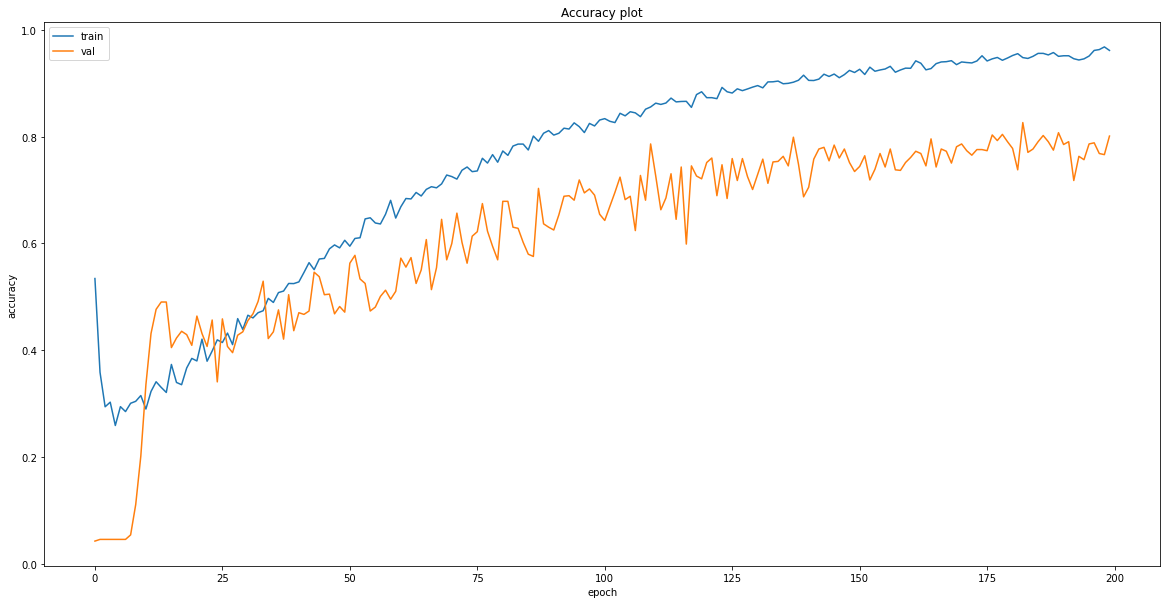

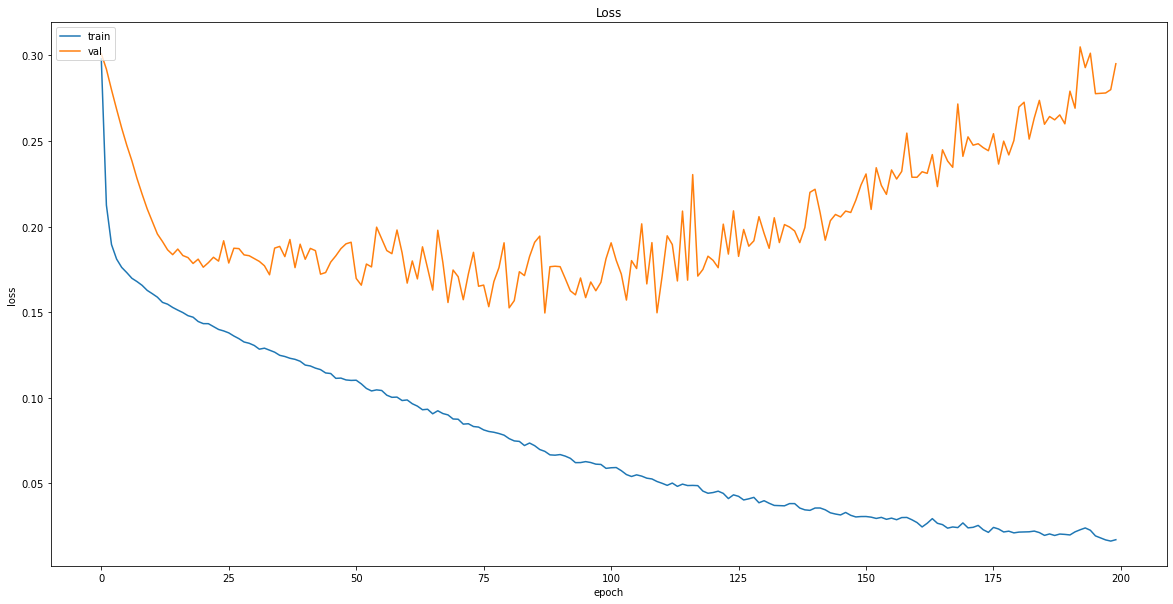

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
# Save model
model.save("models/{}".format('MFC_support_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/MFC_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [71]:
logger = []

In [72]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        16.10  15.369379  -4.347841  12991200.0     2.0
2019-01-23        15.75  15.427936 -19.565241  11195700.0     2.0
2019-01-24        15.79  15.483638 -19.902947  12310800.0     2.0
2019-01-25        15.63  15.506155 -34.131754  10454700.0     2.0
2019-01-28        15.75  15.543670 -30.405447  11863600.0     2.0


In [73]:
df2 = pd.read_csv("data/variation 6/initial_indicators/JPM_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,104.589996,101.198442,-3.459880,84335200.0,2.0
2019-01-23,102.940002,101.466374,-21.874992,67251500.0,2.0
2019-01-24,102.680000,101.653086,-27.040213,55104800.0,2.0
2019-01-25,102.739998,101.820303,-32.628441,66401600.0,2.0
2019-01-28,103.389999,102.061795,-23.968276,80771000.0,2.0


In [74]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2019-01-22,16.10,15.369379,-4.347841,12991200.0,104.589996,2.0
2019-01-23,15.75,15.427936,-19.565241,11195700.0,102.940002,2.0
2019-01-24,15.79,15.483638,-19.902947,12310800.0,102.680000,2.0
2019-01-25,15.63,15.506155,-34.131754,10454700.0,102.739998,2.0
2019-01-28,15.75,15.543670,-30.405447,11863600.0,103.389999,2.0


In [75]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [76]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(218, 15, 5)

In [77]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [78]:
model = tf.keras.models.load_model("models/MFC_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2610 - accuracy: 0.8440 - mean_squared_error: 14.6602 - weighted_accuracy: 0.8440 - weighted_mean_squared_error: 14.6602
Test loss: 0.26097795367240906
Test accuracy: 0.8440366983413696


In [79]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 200, 0: 11, 1: 7})

In [80]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 10, 2: 198, 0: 10})

In [81]:
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test.csv")
df.set_index('Date', inplace=True)

In [82]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,15.630000,15.794888,-75.000000,15118200.0,1.0,2,1
2019-02-12,15.960000,15.769520,-80.303008,13534100.0,2.0,2,2
2019-02-13,15.800000,15.798825,-30.303008,15499400.0,2.0,2,2
2019-02-14,16.040001,15.799006,-54.545415,12941900.0,2.0,2,2
2019-02-15,16.230000,15.836082,-41.935404,16615800.0,2.0,2,2


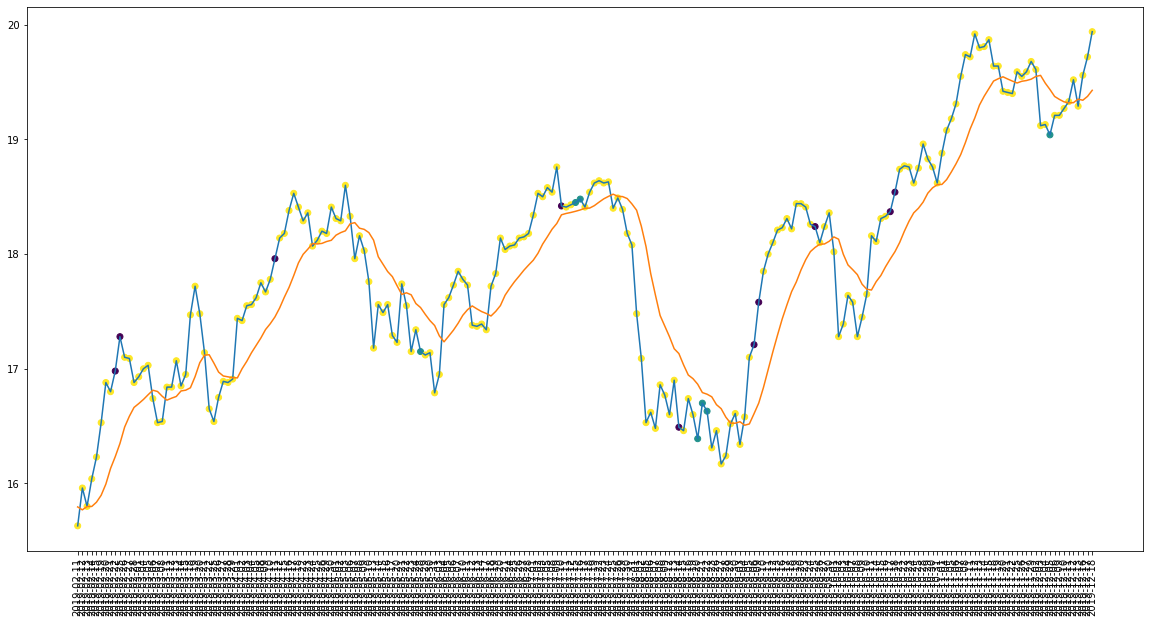

In [83]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

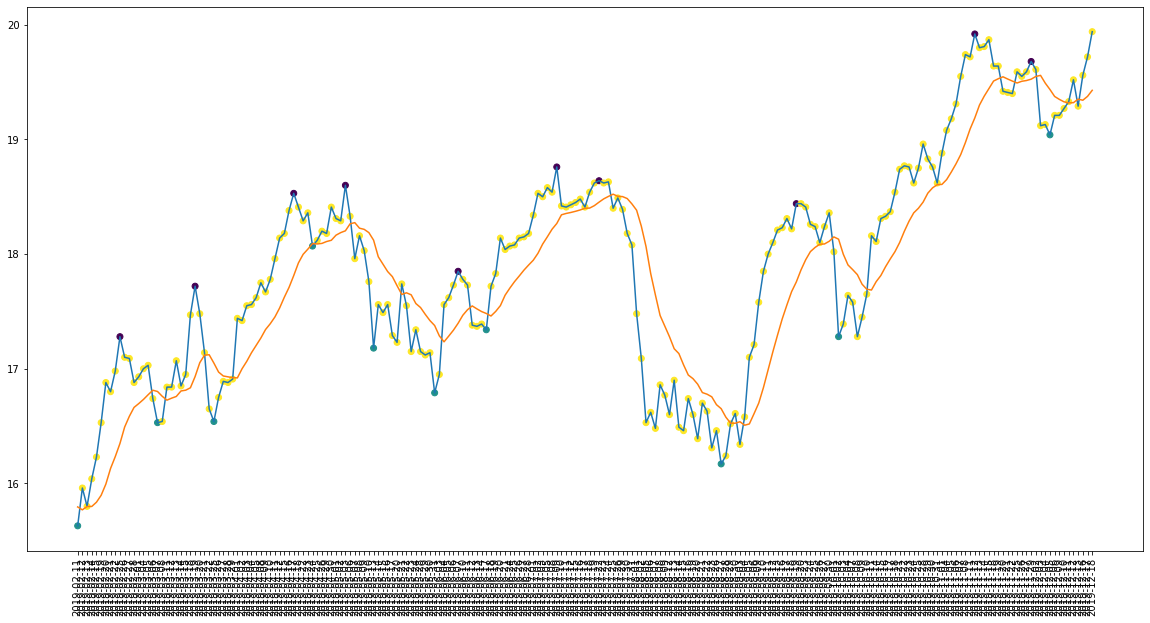

In [84]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [85]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 6
actual holds but predicted sell: 10
actual predicted holds: 182
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 91.91919191919192%
actual buys: 10
actual sells: 10
actual holds: 198


In [86]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[15.630000114440918, 15.800000190734865, 15.960000038146973, 16.040000915527347, 16.229999542236328, 16.530000686645508, 16.799999237060547, 16.879999160766598, 16.979999542236328]
[16.799999237060547, 16.879999160766598, 16.879999160766598, 16.930000305175778, 16.979999542236328, 17.0, 17.09000015258789, 17.100000381469727, 17.280000686645508]
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 20.0%
Percentage holds correct: 83.5%


In [87]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $17.149999618530273
Shares owned at the moment: 581
Cash capital at the moment: $8.448809743404126


Price increase from previously bought: 7.110696232663161%
Share price: $18.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $10681.038298948288


Share price: $18.450000762939453
Shares owned at the moment: 577
Cash capital at the moment: $6.112320021627966


Stop Loss Activated!

Share price: $17.479999542236328
Shares owned at the moment: 0
Cash capital at the moment: $10064.335666618346


Share price: $16.389999389648438
Shares owned at the moment: 612
Cash capital at the moment: $6.07167118072357


Price increase from previously bought: 6.96637071952293%
Share price: $17.579999923706055
Shares owned at the moment: 0
Cash capital at the moment: $10735.444484617232


Share price: $19.040000915527344
Shares owned at the moment: 562
Cash capital at the moment: $5.537648675915989




Capital at the end of test period: $11181.000677990909
profit gaine

In [88]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12687.37270157766
profit gained: 26.873727015776605%


In [89]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.811927,10.0%,10.0%,88.38383838383838%,80.0%,41.1764705882353%,86.38743455497382%,13.093821278943887%,26.470607641010265%
1,0.826484,12.5%,36.36363636363637%,88.0%,85.71428571428571%,63.63636363636363%,84.73684210526316%,31.517885728459333%,-13.262458691596985%
2,0.844037,10.0%,10.0%,91.91919191919192%,28.571428571428573%,20.0%,83.5%,11.810006779909092%,26.873727015776605%


### recession test data

In [90]:
logger = []

In [91]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    20.620001  20.787224 -56.481365  5587900.0     2.0
2020-01-23    20.760000  20.783036 -48.453572  7034300.0     2.0
2020-01-24    20.799999  20.785645 -44.329960  8383300.0     2.0
2020-01-27    20.650000  20.764777 -59.793849  5159000.0     2.0
2020-01-28    20.030001  20.651734 -87.591226  2998800.0     2.0


In [92]:
df2 = pd.read_csv("data/variation 6/initial_indicators/JPM_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,136.839996,137.690058,-77.454723,33776700.0,2.0
2020-01-23,136.679993,137.534664,-80.363881,26227600.0,2.0
2020-01-24,136.539993,137.381637,-69.867648,16881900.0,2.0
2020-01-27,133.149994,136.730615,-90.166021,1715500.0,1.0
2020-01-28,132.029999,136.007444,-79.004573,-11145000.0,2.0


In [93]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2020-01-22,20.620001,20.787224,-56.481365,5587900.0,136.839996,2.0
2020-01-23,20.760000,20.783036,-48.453572,7034300.0,136.679993,2.0
2020-01-24,20.799999,20.785645,-44.329960,8383300.0,136.539993,2.0
2020-01-27,20.650000,20.764777,-59.793849,5159000.0,133.149994,2.0
2020-01-28,20.030001,20.651734,-87.591226,2998800.0,132.029999,2.0


In [94]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(219, 15, 5)

In [95]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [96]:
model = tf.keras.models.load_model("models/MFC_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2809 - accuracy: 0.8402 - mean_squared_error: 14.2323 - weighted_accuracy: 0.8402 - weighted_mean_squared_error: 14.2323
Test loss: 0.2809444069862366
Test accuracy: 0.8401826620101929


In [97]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 199, 1: 8, 0: 12})

In [98]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [99]:
df = pd.read_csv("data/variation 6/initial_indicators/MFC_data_test2.csv")
df.set_index('Date', inplace=True)

In [100]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,20.209999,20.036581,-63.157941,-1529300.0,0.0,2,0
2020-02-12,20.110001,20.063261,-43.421155,-126100.0,2.0,2,2
2020-02-13,19.719999,20.070452,-50.000000,-2453200.0,2.0,2,2
2020-02-14,19.709999,20.016536,-62.626362,-4848700.0,2.0,2,2
2020-02-18,19.580000,19.969377,-63.636486,-6866400.0,2.0,1,2


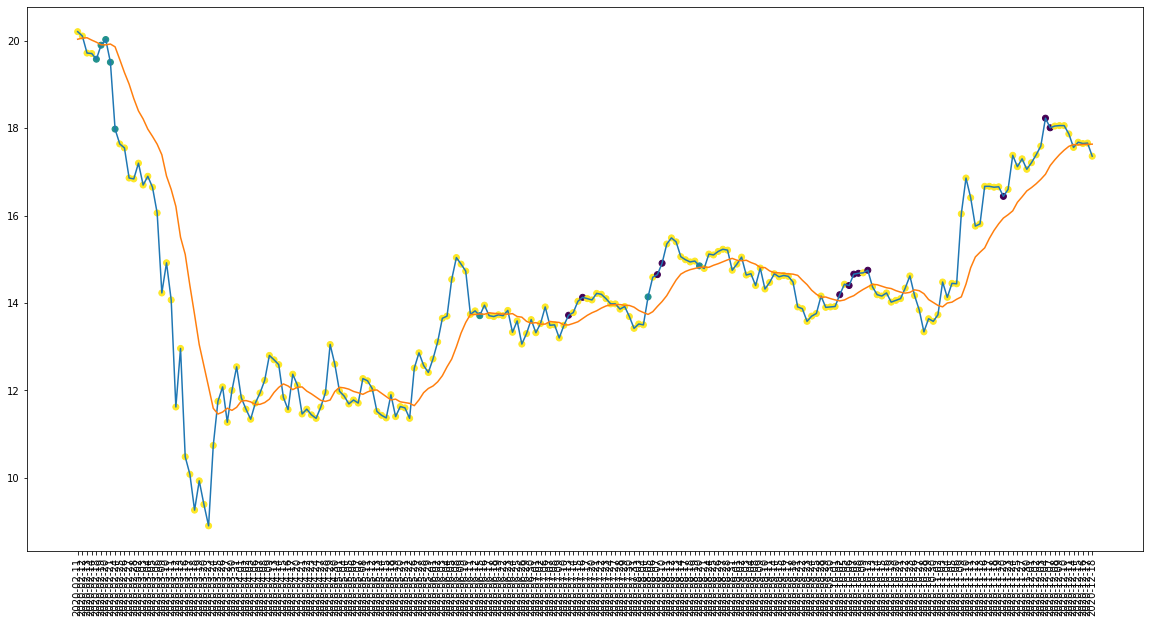

In [101]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

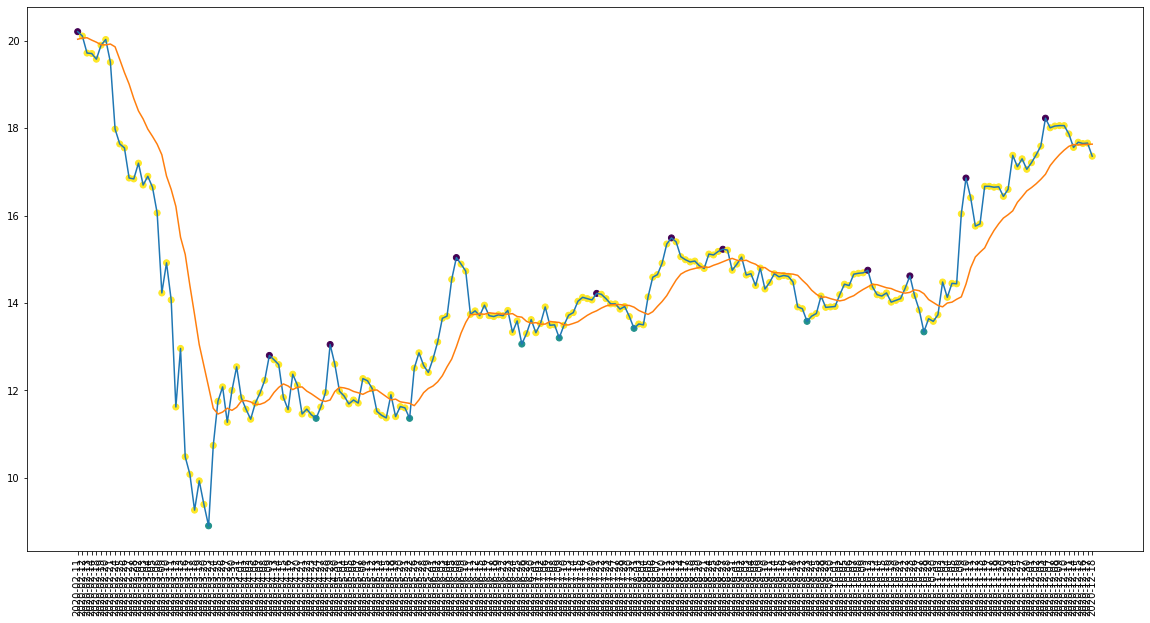

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [103]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 8
actual holds but predicted sell: 10
actual predicted holds: 182
Percentage buys correct: 0.0%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 91.0%
actual buys: 8
actual sells: 11
actual holds: 200


In [104]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[17.979999542236328, 19.51000022888184, 19.57999992370605, 19.709999084472656, 19.71999931335449, 19.899999618530273, 20.030000686645508, 20.11000061035156, 20.209999084472656]
[16.700000762939453, 16.84000015258789, 16.860000610351562, 17.200000762939453, 17.549999237060547, 17.639999389648438, 17.979999542236328, 19.51000022888184, 20.030000686645508]
Percentage buys correct: 37.5%
Percentage sells correct: 41.666666666666664%
Percentage holds correct: 84.34343434343434%


In [105]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $19.57999992370605
Shares owned at the moment: 509
Cash capital at the moment: $6.372933940412622


Stop Loss Activated!

Share price: $17.979999542236328
Shares owned at the moment: 0
Cash capital at the moment: $9133.025196579458


Share price: $17.979999542236328
Shares owned at the moment: 506
Cash capital at the moment: $10.12625884485351


Stop Loss Activated!

Share price: $16.860000610351562
Shares owned at the moment: 0
Cash capital at the moment: $8517.82587683344


Share price: $13.710000038146973
Shares owned at the moment: 619
Cash capital at the moment: $7.9980056555286865


Stop Loss Activated!

Share price: $13.329999923706055
Shares owned at the moment: 0
Cash capital at the moment: $8236.576966059447


Share price: $14.140000343322756
Shares owned at the moment: 580
Cash capital at the moment: $12.823466384646963


Price increase from previously bought: 5.156360922551895%
Share price: $14.90999984741211
Shares owned at the moment: 0
Cash capital at the mo

In [106]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8544.015225172043
profit gained: -14.559847748279573%


In [107]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.811927,10.0%,10.0%,88.38383838383838%,80.0%,41.1764705882353%,86.38743455497382%,13.093821278943887%,26.470607641010265%
1,0.826484,12.5%,36.36363636363637%,88.0%,85.71428571428571%,63.63636363636363%,84.73684210526316%,31.517885728459333%,-13.262458691596985%
2,0.844037,10.0%,10.0%,91.91919191919192%,28.571428571428573%,20.0%,83.5%,11.810006779909092%,26.873727015776605%
3,0.840183,0.0%,18.181818181818183%,91.0%,37.5%,41.666666666666664%,84.34343434343434%,-16.70812264377837%,-14.559847748279573%


In [108]:
experiment

'MFC Variation 6 LSTM Time Series'

In [109]:
log.to_csv('{}.csv'.format(experiment))